# Ordinary Kriging

Kriging is an adavance geostatistical method that generates a perediction of surface from a scattered set of points. Unlike IDW which is purely based on surrounding measured values, the Kriging method uses statistical models to better account for spatial autocorrelation. Kriging can be thought of as a two step process in which first the rule of dependecy is uncovered (variogram), and second the prediction is made based on the knowledge of spatial correlation of data as assessed in the first step.

In [90]:
inLibraries = list('repr','maptools','rgdal','gstat','spdep','raster',
                   'rgeos','geoR','sp','RColorBrewer','classInt','MASS','forecast')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Read in 

a) a digital elevation model (DEM) for Bolivia (bolivia/bolelev.tif), and 

b) the country polygon for Bolivia (bolivia/boliviaborder.shp).  

Create a map that shows the DEM values and includes the boundaries for the country.

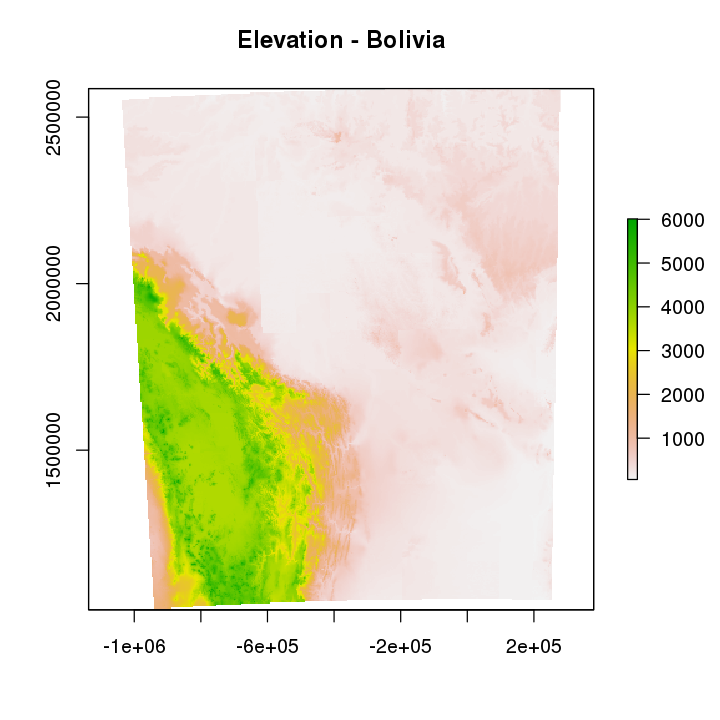

In [172]:
elev <- raster("/dsa/data/geospatial/DS8612/bolivia/bolelev.tif")

plot(elev, main = "Elevation - Bolivia")

In [173]:
res(elev)

[1] 3744.455 3744.455

In [92]:
proj4string(elev)

[1] "+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs"

In [93]:
bol <- readOGR("/dsa/data/geospatial/DS8612/bolivia",
                             "boliviaborder")

summary(bol)

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/bolivia", layer: "boliviaborder"
with 1 features
It has 8 fields


Object of class SpatialPolygonsDataFrame
Coordinates:
       min       max
x -1018795  260396.1
y  1042009 2574906.8
Is projected: TRUE 
proj4string :
[+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0
+ellps=aust_SA +units=m +no_defs]
Data attributes:
    OBJECTID     COUNTRY  ISO_CC         CONTINENT        Land_Type   Land_Rank
 Min.   :58   Bolivia:1   BO:1   South America:1   Primary land:1   Min.   :5  
 1st Qu.:58                                                         1st Qu.:5  
 Median :58                                                         Median :5  
 Mean   :58                                                         Mean   :5  
 3rd Qu.:58                                                         3rd Qu.:5  
 Max.   :58                                                         Max.   :5  
   Shape_Leng      Shape_Area   
 Min.   :64.35   Min.   :91.86  
 1st Qu.:64.35   1st Qu.:91.86  
 Median :64.35   Median :91.86  
 Mean   :64.35   Mean   :91.86  
 3rd 

In [94]:
head(bol@data)

,OBJECTID,COUNTRY,ISO_CC,CONTINENT,Land_Type,Land_Rank,Shape_Leng,Shape_Area
0,58,Bolivia,BO,South America,Primary land,5,64.35451,91.86441


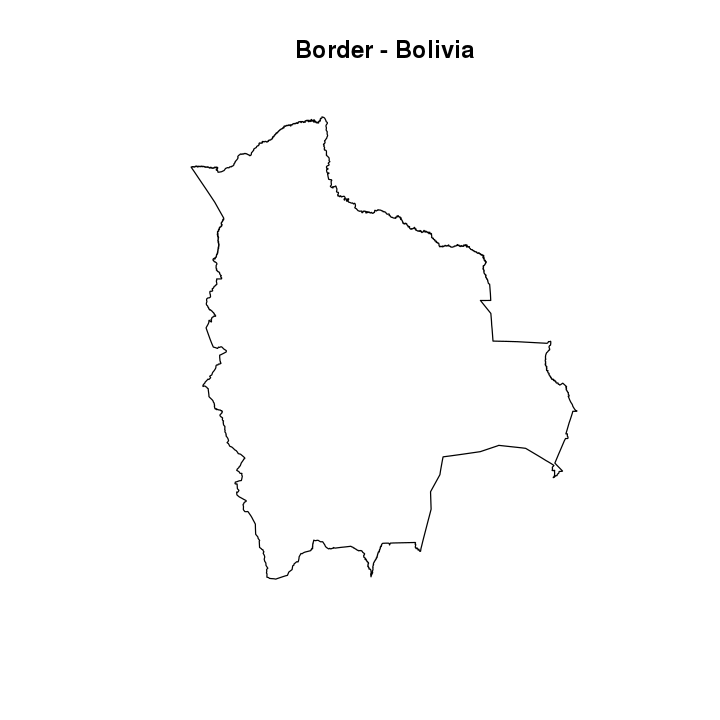

In [95]:
plot(bol, col = "white", main = "Border - Bolivia")

In [96]:
# let's sync up the CRS

elev_CRS <- proj4string(elev)

elev_CRS

[1] "+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs"

In [97]:
res(elev)

[1] 3744.455 3744.455

In [98]:
bol <- spTransform(bol, CRS(elev_CRS))

proj4string(bol)

[1] "+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs"

Convert the DEM raster cells to a spatialpoints featureclass. 

In [99]:
elev_sp <- rasterToPoints(elev, 
                              FUN = null, 
                              spatial = TRUE)

In [100]:
summary(elev_sp)

Object of class SpatialPointsDataFrame
Coordinates:
       min       max
x -1036073  278230.4
y  1026192 2583885.4
Is projected: TRUE 
proj4string :
[+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0
+ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs]
Number of points: 137303
Data attributes:
    bolelev    
 Min.   :  55  
 1st Qu.: 192  
 Median : 289  
 Mean   :1009  
 3rd Qu.: 999  
 Max.   :6009  

In [101]:
paste("Number of points: ", length(elev_sp))

[1] "Number of points:  137303"

Generate a validation point featureclass by randomly sampling 2% of the points in the DEM point featureclass (not the raster DEM). 

Select all non-sampled points and place them in a separate set of points that can be used later for interpolation. 


Output the number of points sampled as well as the number of points that remain for interpolation.  

In [102]:
numsamples <- round((0.02 * length(elev_sp)))
numsamples

[1] 2746

In [103]:
dl <- length(elev_sp)
dl

[1] 137303

In [104]:
samp.rand <- elev_sp[sample(dl, numsamples), ]
samp.rand[1:5, ]

               coordinates bolelev
56864  (158407.8, 1962306)     417
91805 (-568016.5, 1569138)    1989
21092   (-193571, 2351729)     224
79364  (68540.87, 1711427)     301
76627 (-174848.7, 1741383)     276

In [105]:
cc <- as.numeric(row.names(samp.rand))
cc[1:5]

[1] 56864 91805 21092 79364 76627

In [1]:
inFeature.vld <- elev_sp[samp.rand, ]
inFeature.est <- elev_sp[!(row.names(elev_sp) %in% cc), ]

numberVld <- length(inFeature.vld)
numberEst <- length(inFeature.est)

paste("Number of Validation Points:", numberVld)
paste("Number of Interpolation Points:", numberEst)

ERROR: Error in eval(expr, envir, enclos): object 'elev_sp' not found


a) Generate a systematic regular sample of 1,000 points from the DEM raster to ensure samples are drawn from the full geographic extent of Bolivia, 

b) generate a 2% random sample of points from the DEM point featureclass in which higher probabilities of selection are assigned to points with higher elevation in order to better sample the Western portion of the country where there is higher variability in elevation, 

c) combine the points sampled here using inflated probabilities of selection with the 1,000 regular sample of points obtained earlier (hint: check out the spRbind() function in the maptools library, 

d) remove any duplicate points in the combined dataset

e) remove any points in the combined dataset that have na/null values

f) map the combined sample of points (render each of the two different samples as a different color point), overlaying the country polygon and adding an appropriate title.

In [107]:
n <- 1000
samp.reg <- sampleRegular(elev, n, sp = TRUE)
samp.reg$col <- "blue"

In [108]:
samp.reg[1:5, ]

           coordinates bolelev  col
1  (-1017351, 2565163)      NA blue
2 (-972417.7, 2565163)      NA blue
3 (-927484.3, 2565163)      NA blue
4 (-882550.8, 2565163)      NA blue
5 (-833872.9, 2565163)      NA blue

In [109]:
dim(samp.reg)

[1] 986   2

In [110]:
n <- numsamples
N <- length(inFeature.est)

pr1 <- c(inFeature.est$bolelev) / max(inFeature.est$bolelev)

samp.hi <- inFeature.est[sample(N, n, replace = TRUE, prob = pr1), ]
samp.hi$col <- "red"
dim(samp.hi)

[1] 2746    2

In [111]:
samp.hi[1:5, ]

                coordinates bolelev col
79436  (-912506.4, 1707683)    3832 red
68754  (-822639.5, 1827505)    3517 red
80200  (-549294.3, 1700194)    2823 red
100992   (-695328, 1464293)    3687 red
103658 (-538060.9, 1434338)    3255 red

In [167]:
samp.combine <- spRbind(samp.reg, samp.hi)
dim(samp.combine)

[1] 3732    2

In [170]:
samp.combine[1:5, ]

           coordinates bolelev  col
1  (-1017351, 2565163)      NA blue
2 (-972417.7, 2565163)      NA blue
3 (-927484.3, 2565163)      NA blue
4 (-882550.8, 2565163)      NA blue
5 (-833872.9, 2565163)      NA blue

In [113]:
unique <- samp.combine[-zerodist(samp.combine)[, 1], ]
dim(unique)

[1] 3638    2

In [114]:
unique[1:5, ]

           coordinates bolelev  col
1  (-1017351, 2565163)      NA blue
2 (-972417.7, 2565163)      NA blue
3 (-927484.3, 2565163)      NA blue
4 (-882550.8, 2565163)      NA blue
5 (-833872.9, 2565163)      NA blue

In [115]:
unique.valid <- unique[!is.na(unique$bolelev), ]
dim(unique.valid)

[1] 3576    2

In [116]:
unique.valid[3000:3005, ]

                coordinates bolelev col
136818 (-758983.8, 1048659)    4439 red
114780 (-384538.2, 1307026)     913 red
58596  (-972417.7, 1939839)    4362 red
111573 (-223526.6, 1344471)     380 red
33925  (-40048.34, 2213184)     318 red
74804  (-747750.4, 1760105)    2960 red

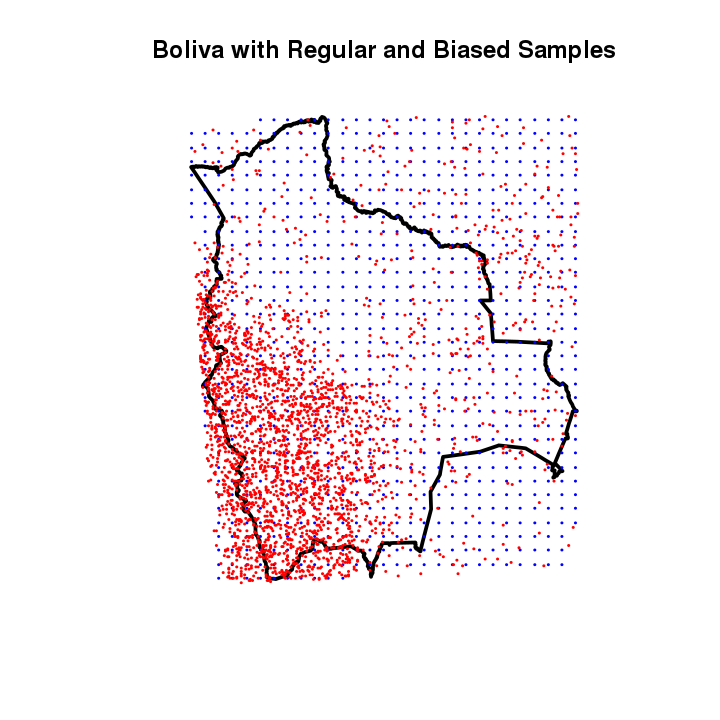

In [117]:
# just plot with the col as color category
plot(bol, main = "Boliva with Regular and Biased Samples", lwd = 3)
plot(unique.valid, 
     col = unique.valid$col, 
     add = TRUE, 
     pch = 20,
     cex = 0.3)

In [118]:
pp <- unique.valid[, 1]

pp[1:5, ]

            coordinates bolelev
6  (-788939.4, 2565163)     204
7  (-744005.9, 2565163)     203
8  (-699072.5, 2565163)     197
9    (-654139, 2565163)     200
10 (-609205.6, 2565163)     184

Create an Interpolation grid dataframe that covers the same extent as the DEM raster. The cellsize of the interpolation grid should be the same cell size as the DEM raster. 

In [119]:
c <- coordinates(elev_sp)

c[1:5, ]

x,y
-245993.4,2583885
-242248.9,2583885
-238504.5,2583885
-234760.0,2583885
-231015.6,2583885


In [120]:
minlon <- min(c[, 1])
maxlon <- max(c[, 1])

minlat <- min(c[, 2])
maxlat <- max(c[, 2])

In [121]:
paste(minlon, "|", maxlon, "|", minlat, "|", maxlat)

[1] "-1036073.46740118 | 278230.371027245 | 1026191.92690126 | 2583885.36503865"

In [122]:
long.range <- as.numeric(c(minlon, maxlon))

long.range

[1] -1036073.5   278230.4

In [123]:
lat.range <- as.numeric(c(minlat, maxlat))

lat.range

[1] 1026192 2583885

In [124]:
cellsize <- 3744 

grd <- expand.grid(x = seq(
                            from = long.range[1],
                            to = long.range[2],
                            by = cellsize),
                   y = seq(
                            from = lat.range[1],
                            to = lat.range[2],
                            by = cellsize))

grd[1:5, ]

x,y
-1036073,1026192
-1032329,1026192
-1028585,1026192
-1024841,1026192
-1021097,1026192


In [125]:
coordinates(grd) <- ~x + y

In [126]:
coordinates(grd)[1:5, ]

,x,y
1,-1036073,1026192
2,-1032329,1026192
3,-1028585,1026192
4,-1024841,1026192
5,-1021097,1026192


In [127]:
gridded(grd) <- TRUE

gridded(grd)

[1] TRUE

In [128]:
proj4string(grd) <- proj4string(elev_sp)

proj4string(grd)

[1] "+proj=aea +lat_1=-5 +lat_2=-42 +lat_0=-32 +lon_0=-60 +x_0=0 +y_0=0 +ellps=aust_SA +towgs84=-57,1,-41,0,0,0,0 +units=m +no_defs"

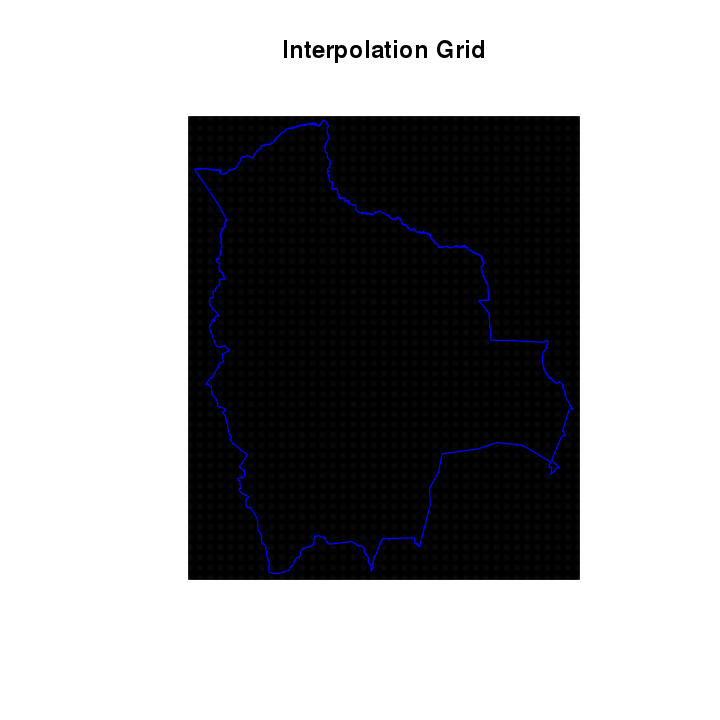

In [129]:
plot(grd, main = "Interpolation Grid")
plot(bol, add = TRUE, border = "blue")

a) Create an empirical variogram given the sample data, 

b) fit an exponential model to the empirical variogram, 

c) display the parameters of the estimated variogram, and 

d) plot the fitted variogram to the screen.

In [130]:
inVa <- pp$bolelev

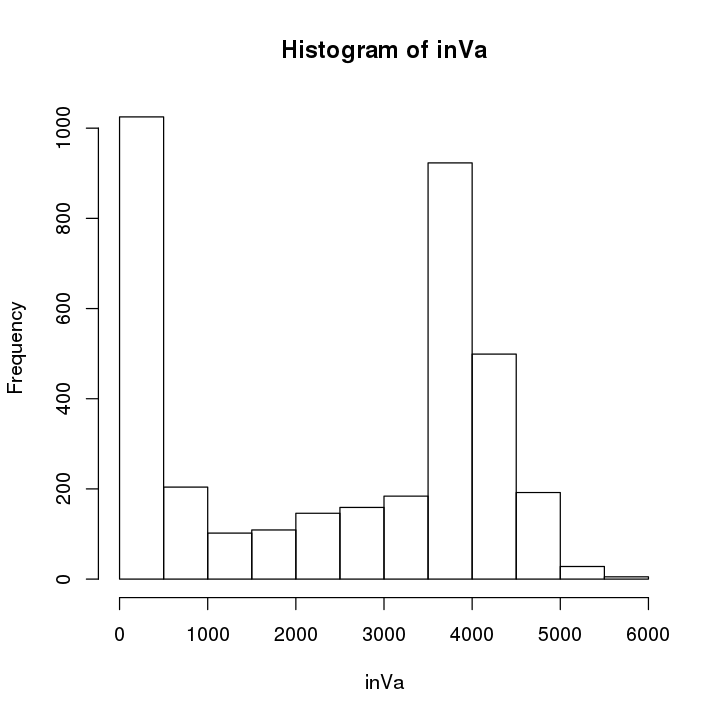

In [131]:
hist(inVa)

In [132]:
shapiro.test(inVa)


	Shapiro-Wilk normality test

data:  inVa
W = 0.84525, p-value < 2.2e-16


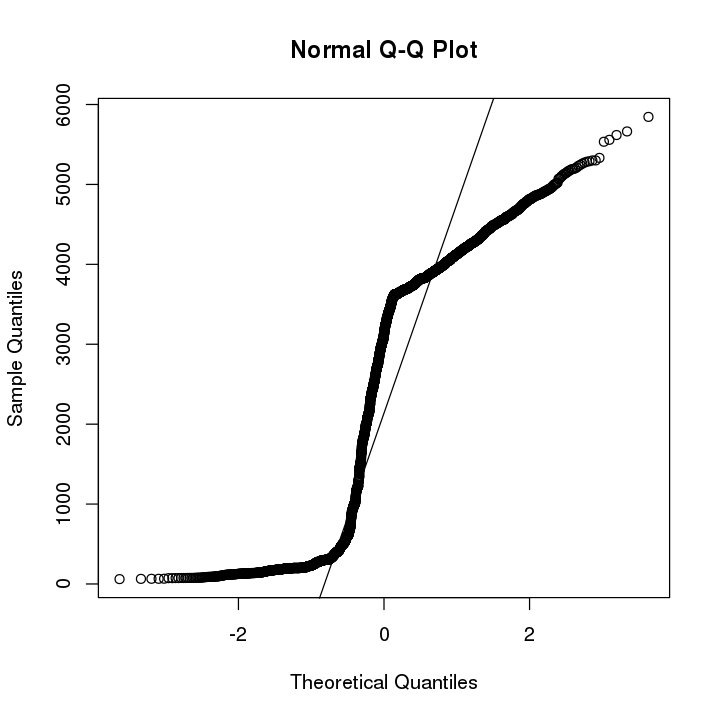

In [133]:
qqnorm(inVa)
qqline(inVa)

The kriging interpoliation technique assumes the data is normally distributed. Looks like we'll have to transform the data a bit using the BoxCox transformation. 

In [134]:
lambda <- BoxCox.lambda(inVa, method = "guerrero", 
                           lower = -4, upper = 4)

lambda

[1] 2.659972

In [135]:
tva <- BoxCox(inVa, lambda)

tva[1:5]

[1] 523207.1 516412.7 476801.9 496360.7 397625.3

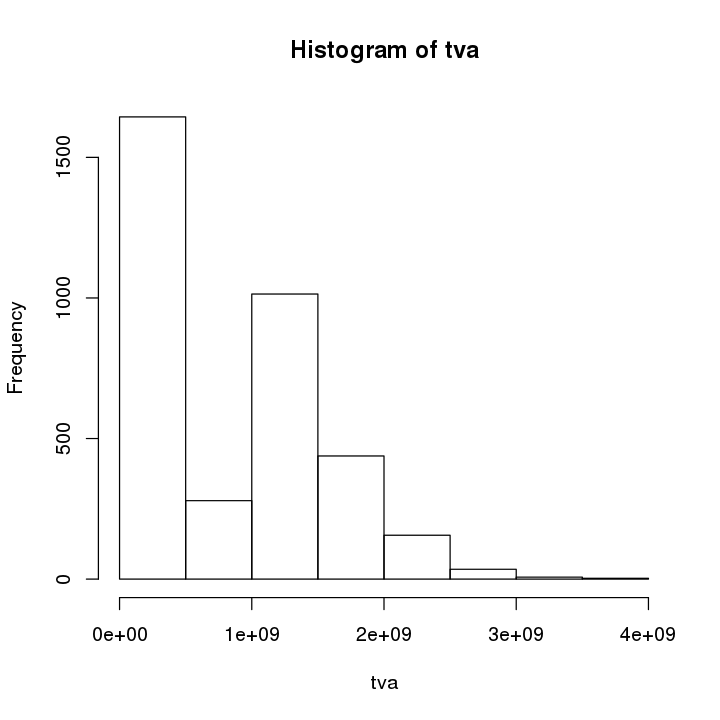

In [136]:
hist(tva)

In [137]:
shapiro.test(tva)


	Shapiro-Wilk normality test

data:  tva
W = 0.87022, p-value < 2.2e-16


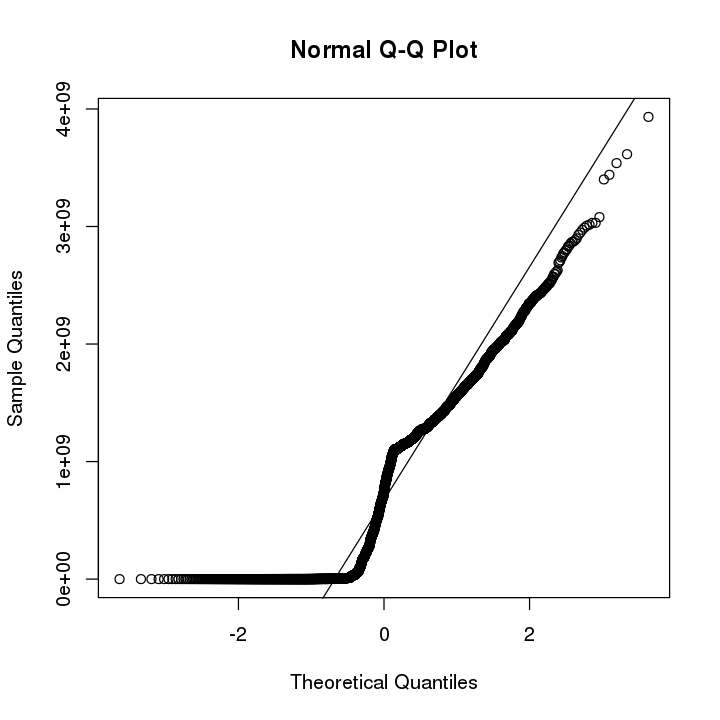

In [138]:
qqnorm(tva)
qqline(tva)

In [139]:
vrg <- variogram(as.numeric(tva) ~ 1,
                    pp, cutoff = 90000)

In [140]:
fit.vrg.exp <- fit.variogram(vrg, 
                                vgm("Exp", fit.kappa = TRUE))

fit.vrg.exp

model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
Nug,6.944671e+15,0.00,0.0,0,0,0,1,1
Exp,2.094464e+17,41510.53,0.5,0,0,0,1,1


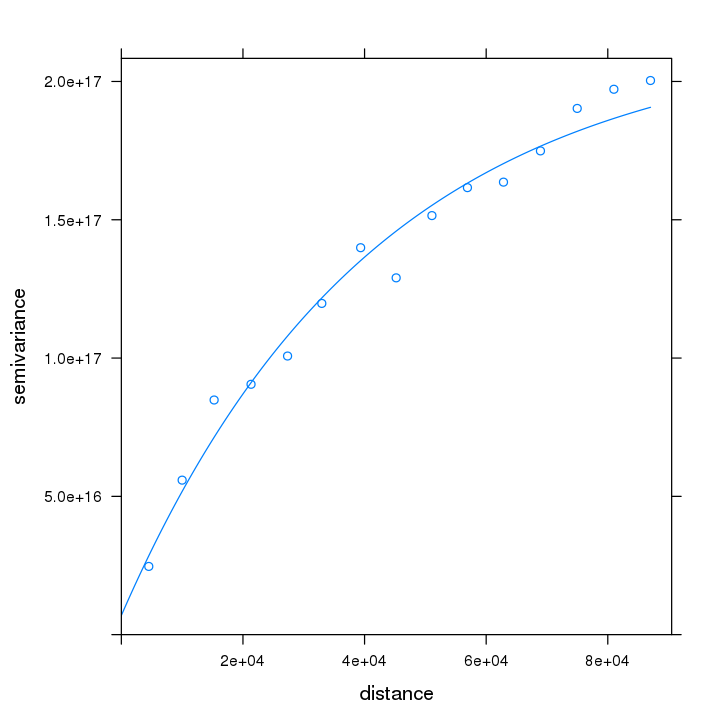

In [141]:
plot(vrg, fit.vrg.exp)

Conduct an ordinary kriging using the sampled elevation points. 

Interpolate each cell value based upon the values of it's nearest 1 to 50 sample points. 

In [142]:
ok.exp <- krige(tva ~ 1, 
                   pp, 
                   nmin = 1, nmax = 50,
                   grd, 
                   fit.vrg.exp)

names(ok.exp)

rvals <- ok.exp@data$var1.pred

[using ordinary kriging]


[1] "var1.pred" "var1.var"

In [143]:
# backtransform

btrvals <- InvBoxCox(ok.exp@data$var1.pred, lambda)
ok.exp@data$btvar1.pred <- InvBoxCox(ok.exp@data$var1.pred, lambda)

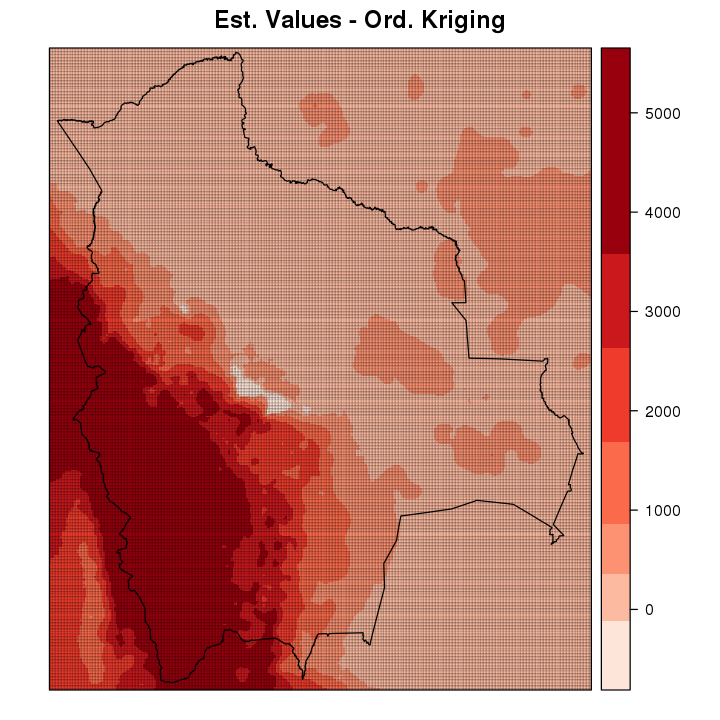

In [144]:
numcat <- 7
cate <- classIntervals(btrvals, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat, "Reds")

spplot(ok.exp["btvar1.pred"], 
                  col.regions = color.pal,
                  main = "Est. Values - Ord. Kriging", 
                  at = cate$brks, cex.main = 0.8,
                  panel = function(...){
                      panel.gridplot(..., border = "black")
                      sp.polygons(bol)
                  })

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 7339200)”

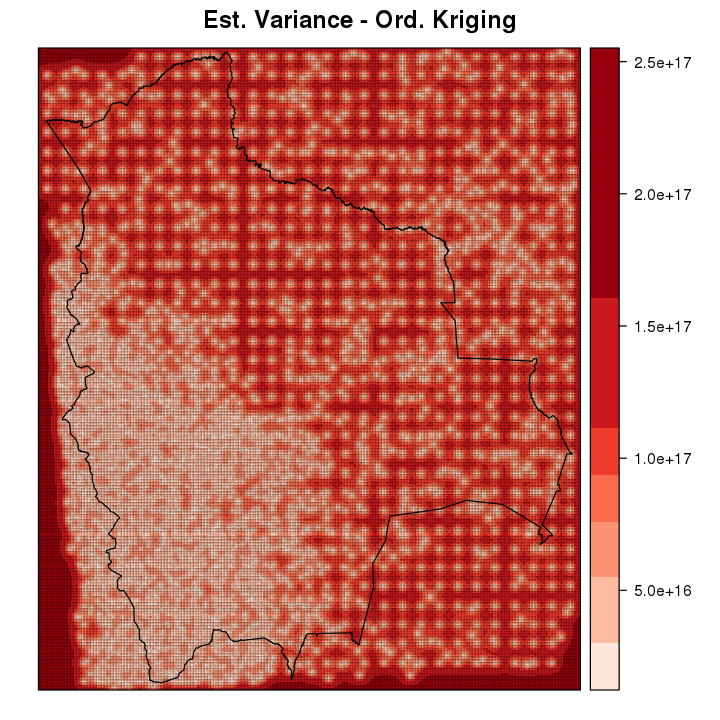

In [145]:
varvals <- ok.exp@data$var1.var

numcat <- 7
cate2 <- classIntervals(varvals, numcat, style = "kmeans")
color.pal2 <- brewer.pal(numcat, "Reds")

spplot(ok.exp["var1.var"], col.regions = color.pal2,
          at = cate2$brks, main = "Est. Variance - Ord. Kriging",
          cex.main = 0.8, 
          panel = function(...){
              panel.gridplot(..., border = "black")
              sp.polygons(bol)
          })

Link the validation points with the predicted value at their location, storing the output as a new point dataset named 'validationA'. 

Print the first 5 lines of the linked validation point attributes that show the elevation and predicted fields.

In [146]:
pred.exp <- over(inFeature.vld, ok.exp)
predCompare <- cbind(inFeature.vld@data, pred.exp$btvar1.pred)
head(predCompare, 10)

,bolelev,pred.exp$btvar1.pred
72,252,259.9841
79,274,245.7550
91,285,212.0828
147,100,191.8204
212,197,210.9797
260,324,241.9784
333,132,197.1566
347,100,171.3094
403,201,199.8742
471,179,252.6723


In [147]:
names(ok.exp)

[1] "var1.pred"   "var1.var"    "btvar1.pred"

In [148]:
predRaster <- raster(ok.exp, layer = 3)

In [149]:
validationA <- extract(predRaster, inFeature.vld, sp = TRUE)
validationA <- validationA[!is.na(validationA@data$btvar1.pred), ]

In [150]:
validationA[1:10, ]

             coordinates bolelev btvar1.pred
72   (19862.95, 2583885)     252    259.9841
79   (46074.14, 2583885)     274    245.7550
91    (91007.6, 2583885)     285    212.0828
147 (-373304.9, 2580141)     100    191.8204
212 (-129915.3, 2580141)     197    210.9797
260  (49818.59, 2580141)     324    241.9784
333 (-508105.3, 2576396)     132    197.1566
347 (-455682.9, 2576396)     100    171.3094
403 (-245993.4, 2576396)     201    199.8742
471  (8629.584, 2576396)     179    252.6723

a) Add a new field to the linked validation point set (validationA) named 'error.exp', 

b) In this new field, compute the error between the sampled and predicted values associated with the validation points, 

c) compute the RMSE for the validation points and output the RMSE to the screen.

In [151]:
validationA@data$error.exp <- validationA@data$btvar1.pred - validationA@data$bolelev 

In [152]:
validationA[1:5, ]

             coordinates bolelev btvar1.pred  error.exp
72   (19862.95, 2583885)     252    259.9841   7.984056
79   (46074.14, 2583885)     274    245.7550 -28.244969
91    (91007.6, 2583885)     285    212.0828 -72.917215
147 (-373304.9, 2580141)     100    191.8204  91.820426
212 (-129915.3, 2580141)     197    210.9797  13.979749

In [153]:
RMSE <- (mean((validationA@data$error.exp)^2))^0.5

paste("RMSE:", RMSE)

[1] "RMSE: 181.461473644389"

Categorize the interpolation error into 5 quantiles and map the error distribution to evaluate where over and under-prediction occured in the validation point set.

In [154]:
shapiro.test(validationA@data$error.exp)


	Shapiro-Wilk normality test

data:  validationA@data$error.exp
W = 0.7002, p-value < 2.2e-16


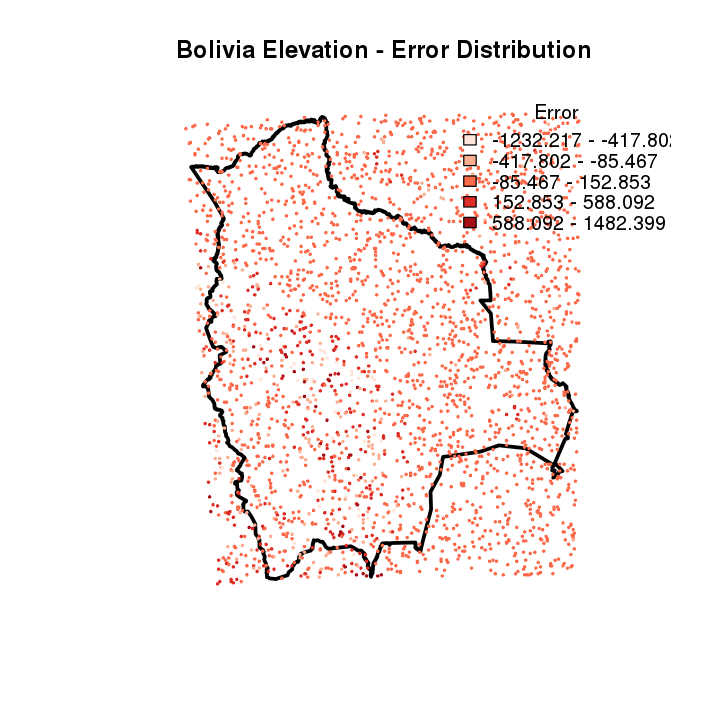

In [155]:
numcat <- 5
q <- classIntervals(validationA@data$error.exp, numcat, style = "kmeans")
pal <- brewer.pal(5, "Reds")
cols <- findColours(q, pal)

plot(bol, main = "Bolivia Elevation - Error Distribution", lwd = 3)

plot(inFeature.vld, col = cols, pch = 20, lwd = 0.4, add = TRUE, cex = 0.5)

brks <- round(q$brks, 3)
leg <- paste(brks[-6], brks[-1], sep = " - ")
legend("topright", fill = pal, legend = leg, bty = "n", title = "Error")

a) Repeat the kriging process again, only this time considering between 1 and 3 nearest sample points in the interpoloation.

b) link the intepolated values to the validation points as before in a new point file name validationB, 

c) add a new field to the linked validation point set (validationB) named 'error.exp', 

d) In this new field, compute the error between the sampled and predicted values associated with the validation points, 

e) compute the RMSE for the validation points and output the RMSE to the screen. Output a message to the screen stating how much the kriging results improved or worsened when including only the nearest 1-3 nearest points vs. the 1-50 nearest points.

In [156]:
ok.exp2 <- krige(tva ~ 1, 
                     pp, 
                     nmin = 1, 
                     nmax = 3, 
                     grd, fit.vrg.exp)

names(ok.exp2)

rvals2 <- ok.exp2@data$var1.pred

[using ordinary kriging]


[1] "var1.pred" "var1.var"

In [157]:
btrvals2 <- InvBoxCox(ok.exp2@data$var1.pred, lambda)
ok.exp2@data$btvar2.pred <- InvBoxCox(ok.exp2@data$var1.pred, lambda)

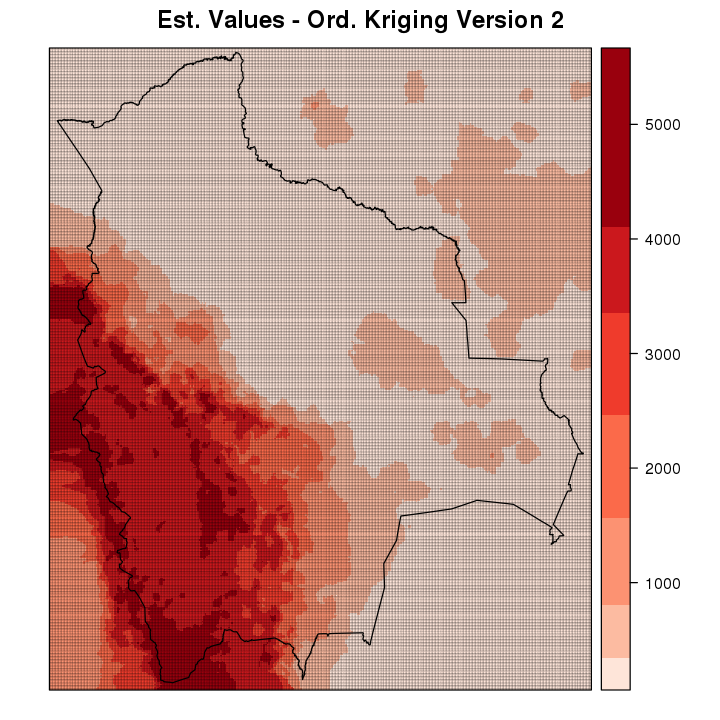

In [158]:
numcat <- 7
cate <- classIntervals(btrvals2, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat, "Reds")

spplot(ok.exp2["btvar2.pred"],
                  col.regions = color.pal, 
                  main = "Est. Values - Ord. Kriging Version 2",
                  at = cate$brks, cex.main = 0.8,
                  panel = function(...){
                      panel.gridplot(..., border = "black")
                      sp.polygons(bol)
                  })

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 7339200)”

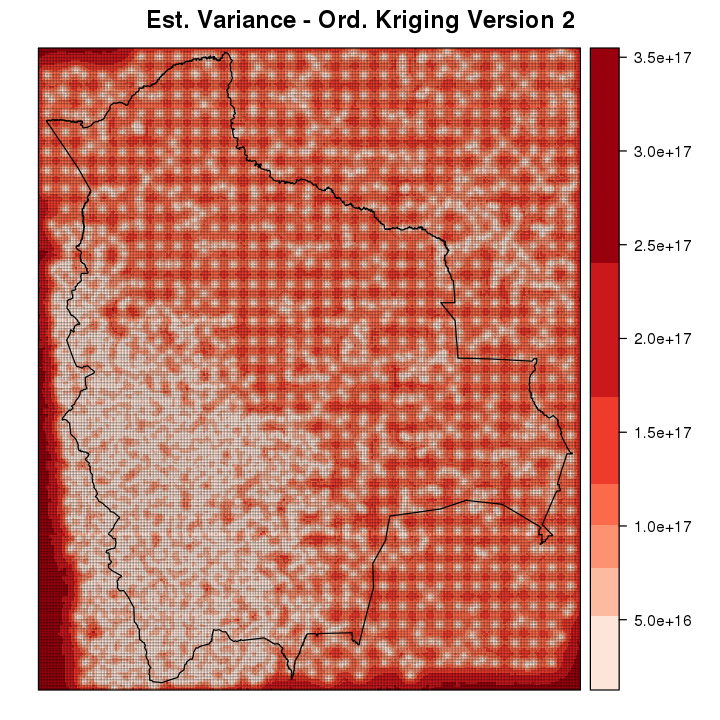

In [159]:
varvals2 <- ok.exp2@data$var1.var

numcat <- 7
cate <- classIntervals(varvals2, numcat, style = "kmeans")
color.pal <- brewer.pal(numcat, "Reds")

spplot(ok.exp2["var1.var"], col.regions = color.pal, 
          at = cate$brks, main = "Est. Variance - Ord. Kriging Version 2", 
          cex.main = 0.8, 
          panel = function(...){
              panel.gridplot(..., border = "black")
              sp.polygons(bol)
          })

In [160]:
names(ok.exp2)

[1] "var1.pred"   "var1.var"    "btvar2.pred"

In [161]:
predRaster2 <- raster(ok.exp2, layer = 3)

In [162]:
validationB <- extract(predRaster2, inFeature.vld, sp = TRUE)
validationB <- validationB[!is.na(validationB@data$btvar2.pred), ]

validationB[1:10, ]

             coordinates bolelev btvar2.pred
72   (19862.95, 2583885)     252    261.0551
79   (46074.14, 2583885)     274    246.0588
91    (91007.6, 2583885)     285    182.6171
147 (-373304.9, 2580141)     100    177.3196
212 (-129915.3, 2580141)     197    211.6439
260  (49818.59, 2580141)     324    241.1138
333 (-508105.3, 2576396)     132    184.8886
347 (-455682.9, 2576396)     100    147.5374
403 (-245993.4, 2576396)     201    192.9181
471  (8629.584, 2576396)     179    250.0262

In [163]:
validationB@data$error.exp <- validationB@data$btvar2.pred - validationB@data$bolelev

validationB[1:5, ]

             coordinates bolelev btvar2.pred   error.exp
72   (19862.95, 2583885)     252    261.0551    9.055107
79   (46074.14, 2583885)     274    246.0588  -27.941188
91    (91007.6, 2583885)     285    182.6171 -102.382908
147 (-373304.9, 2580141)     100    177.3196   77.319609
212 (-129915.3, 2580141)     197    211.6439   14.643878

In [164]:
RMSE2 <- (mean((validationB@data$error.exp)^2))^0.5

paste("RMSE for Version 2:", RMSE2)

[1] "RMSE for Version 2: 179.530783080315"

In [165]:
shapiro.test(validationB@data$error.exp)


	Shapiro-Wilk normality test

data:  validationB@data$error.exp
W = 0.67758, p-value < 2.2e-16


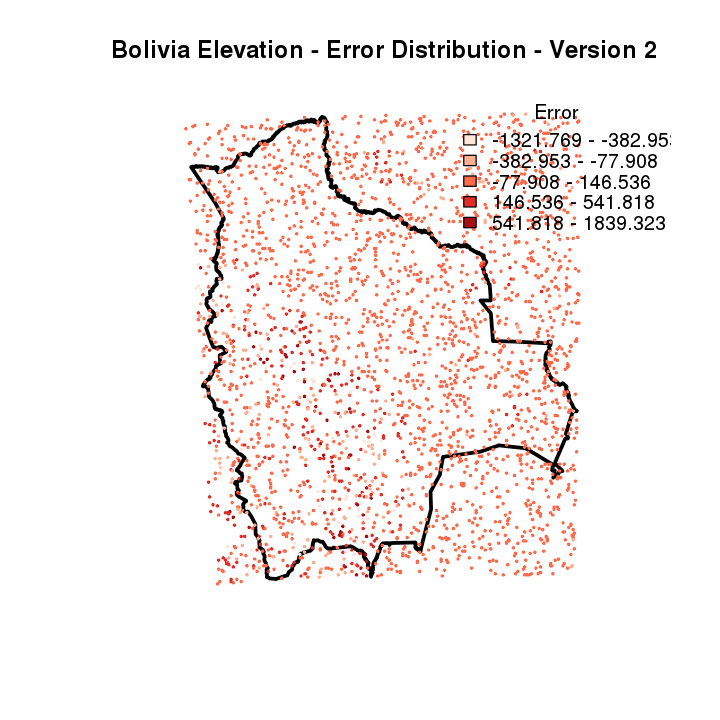

In [171]:
numcat <- 5
q <- classIntervals(validationB@data$error.exp, numcat, style = "kmeans")
pal <- brewer.pal(5, "Reds")
cols <- findColours(q, pal)

plot(bol, main = "Bolivia Elevation - Error Distribution - Version 2", lwd = 3)
plot(inFeature.vld, col = cols, pch = 20, lwd = 0.4, add = TRUE, cex = 0.5)


brks <- round(q$brks, 3)
leg <- paste(brks[-6], brks[-1], sep = " - ")
legend("topright", fill = pal, legend = leg, bty = "n", title = "Error")